In [1]:
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf


In [2]:
# 预处理输入数据
def preprocessing(nmp_df,power_df):
    nmp_df.head(10)
    power_df.head(10)
    fix_df=pd.merge(nmp_df, power_df, on=['Datetime'], how='left')
#     print(fix_df.head(10))
#     print(fix_df.describe())
    return fix_df

In [3]:
# 读取数据
his_nmp_fd_df = pd.read_csv('.\\data\\FD001\\03 His_NWP_FD.csv',parse_dates=["Datetime"],index_col=[0])
his_power_fd_df = pd.read_csv('.\\data\\FD001\\02_His_Power_FD.csv',parse_dates=["Datetime"],index_col=[0])
his_fd_df=preprocessing(his_nmp_fd_df,his_power_fd_df)
his_fd_df.to_csv('his_df.csv',encoding = 'utf-8') #存储合并后数据

In [4]:
df=pd.read_csv('his_df.csv',parse_dates=["Datetime"],index_col=[0])
df.head()

,Speed10,Direction10,Speed30,Direction30,Speed50,Direction50,Speed70,Direction70,Speed90,Direction90,Speed100,Direction100,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,,,,,,,,,,
2022-07-15 00:00:00,3.3696,290.3172,4.1829,295.0334,4.9253,297.9698,5.6139,300.0360,6.2446,301.5774,6.5423,302.1353,27.59,1003.96,93.20,0.0216
2022-07-15 00:15:00,3.3092,291.4477,4.1100,296.1286,4.8389,299.0546,5.5137,301.1241,6.1388,302.6287,6.4347,303.2702,27.61,1004.37,93.05,0.0218
2022-07-15 00:30:00,3.4671,295.0868,4.2669,299.3285,5.0000,302.0054,5.6718,303.8582,6.2926,305.2307,6.5832,305.7906,27.62,1004.25,92.96,0.4021
2022-07-15 00:45:00,3.6896,296.9123,4.4933,300.7888,5.2253,303.4468,5.9067,305.1430,6.5341,306.5367,6.8241,307.1386,27.62,1003.96,92.82,0.5867
2022-07-15 01:00:00,3.7095,298.4995,4.5220,302.3546,5.2791,304.8942,5.9740,306.6973,6.6113,307.9966,6.9170,308.5434,27.64,1003.68,92.59,0.3889


In [5]:
df.tail()

,Speed10,Direction10,Speed30,Direction30,Speed50,Direction50,Speed70,Direction70,Speed90,Direction90,Speed100,Direction100,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,,,,,,,,,,
2022-07-21 22:45:00,4.5521,307.3230,6.1812,312.0492,7.6793,314.6835,8.4867,316.0503,8.6879,316.8657,8.7815,317.1689,27.90,1009.53,87.03,2.3584
2022-07-21 23:00:00,4.5931,308.9910,5.4076,312.4519,6.1518,314.8683,6.7197,316.4472,6.8998,317.2906,6.9864,317.6105,27.92,1010.14,0.00,2.8011
2022-07-21 23:15:00,3.3338,303.4994,4.6673,310.4815,5.9120,314.1776,6.7329,316.0832,6.9197,316.9911,7.0061,317.3137,27.44,1009.89,0.00,3.6597
2022-07-21 23:30:00,3.2299,299.8989,4.5556,308.4045,5.8027,312.7652,6.6115,314.9387,6.7961,315.8942,6.8890,316.2939,27.46,1009.84,0.00,3.4466
2022-07-21 23:45:00,3.4215,297.3140,4.7503,306.2668,6.0103,311.0873,6.7556,313.3806,6.9372,314.3576,7.0216,314.8269,27.46,1009.69,0.00,3.0725


In [6]:
df.shape

(672, 16)

In [7]:
# 划分train valid test集
fd_df_train = df[:int(0.6*len(df))]
fd_df_valid = df[int(0.6*len(df)):int(0.8*len(df))]
fd_df_test =df[int(0.8*len(df)):]

In [8]:
# 对数据进行归一化处理
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(df)

df_for_training_scaled = scaler.transform(fd_df_train)
df_for_validing_scaled=scaler.transform(fd_df_valid)
df_for_testing_scaled=scaler.transform(fd_df_test)
df_scaled=scaler.transform(df)

In [9]:
# 分离x与y
def createXY(array, days_used_to_train=7):
    features = list()
    labels = list()

    for i in range(days_used_to_train, len(array)):
        features.append(array[i-days_used_to_train:i, :])
        labels.append(array[i, -1])
    return np.array(features), np.array(labels)

train_X,train_y=createXY(df_for_training_scaled)
valid_X,valid_y=createXY(df_for_validing_scaled)
test_X,test_y=createXY(df_for_testing_scaled)
df_scaled_X,df_scaled_y=createXY(df_scaled)

In [10]:
train_X.shape

(396, 7, 16)

In [11]:
train_y.shape

(396,)

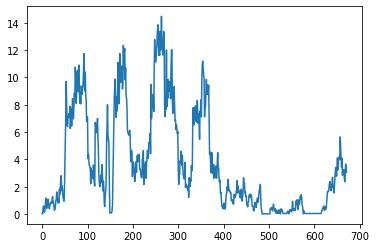

In [12]:
# 看一下历史波形
plt.plot(range(len(df['Power(MW)'])), df['Power(MW)'], label='history')

In [13]:
# 定义一个新的评价函数
def ev(y_true, y_predict):
    difference=((np.array(y_true) - np.array(y_predict.flatten()))**2).sum()
    return float(difference) 

In [14]:
from sklearn.metrics import make_scorer
my_scorer = make_scorer(ev, greater_is_better=True) 
scoring = {
    'ev': my_scorer
}

In [15]:
# 建立模型函数
def build_model(size,sm):
    tf.random.set_seed(sm) #设置随机数种子
    # Create grid_model
    grid_model = tf.keras.Sequential()
    grid_model.add(tf.keras.layers.LSTM(units=64))
    grid_model.add(tf.keras.layers.Dense(64))
    grid_model.add(tf.keras.layers.Dense(size))
    grid_model.add(tf.keras.layers.Dense(1))

    # Compile the grid_model
    grid_model.compile(
    optimizer='adam',
    loss='mse')
    
    return grid_model

In [16]:
from keras.wrappers.scikit_learn import KerasClassifier
grid_model = KerasRegressor(build_fn=build_model)

C:\Users\23966\AppData\Local\Temp\ipykernel_17292\560159353.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model)


In [17]:
def easy_doing(begin,end,step):
    value=[]
    i=begin
    for i in np.arange(begin, end, step):
        value.append(i)
    return value

In [18]:
parameters = {'batch_size' : [16],'epochs' : [40],'size' : [64],'sm':[0,1]}

In [19]:
grid_search = GridSearchCV(estimator = grid_model,
                          param_grid = parameters,
                          scoring=scoring, 

                           refit ='ev', 
                           n_jobs=1,
                           cv = 2)

In [20]:
grid_search = grid_search.fit(train_X, train_y,
    validation_data=(valid_X, valid_y))

Epoch 1/40
13/13 [==============================] - 2s 39ms/step - loss: 0.0789 - val_loss: 0.0166
Epoch 2/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0224 - val_loss: 0.0683
Epoch 3/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0148 - val_loss: 0.0386
Epoch 4/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0144 - val_loss: 0.0071
Epoch 5/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0031
Epoch 6/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0028
Epoch 7/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 0.0052
Epoch 8/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0027
Epoch 9/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0022
Epoch 10/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0076 - val_loss: 0.0026
Epoch 11/40
13/13 

Epoch 3/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0176 - val_loss: 0.0226
Epoch 4/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0122 - val_loss: 0.0176
Epoch 5/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0055
Epoch 6/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0038
Epoch 7/40
13/13 [==============================] - 0s 5ms/step - loss: 0.0082 - val_loss: 0.0058
Epoch 8/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0092
Epoch 9/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0075 - val_loss: 0.0031
Epoch 10/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0076 - val_loss: 0.0028
Epoch 11/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0078 - val_loss: 0.0024
Epoch 12/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0077 - val_loss: 0.0043
Epoch 13/40
13/13

Epoch 5/40
25/25 [==============================] - 0s 4ms/step - loss: 0.0103 - val_loss: 0.0134
Epoch 6/40
25/25 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0035
Epoch 7/40
25/25 [==============================] - 0s 4ms/step - loss: 0.0101 - val_loss: 0.0077
Epoch 8/40
25/25 [==============================] - 0s 4ms/step - loss: 0.0093 - val_loss: 0.0014
Epoch 9/40
25/25 [==============================] - 0s 4ms/step - loss: 0.0087 - val_loss: 0.0048
Epoch 10/40
25/25 [==============================] - 0s 4ms/step - loss: 0.0080 - val_loss: 0.0035
Epoch 11/40
25/25 [==============================] - 0s 4ms/step - loss: 0.0080 - val_loss: 0.0029
Epoch 12/40
25/25 [==============================] - 0s 4ms/step - loss: 0.0088 - val_loss: 0.0026
Epoch 13/40
25/25 [==============================] - 0s 4ms/step - loss: 0.0082 - val_loss: 0.0013
Epoch 14/40
25/25 [==============================] - 0s 4ms/step - loss: 0.0085 - val_loss: 0.0136
Epoch 15/40
25/

In [21]:
##以下为用for循环的方式寻优，可以达到更好的效果，但是不一定预测更准
# # 为循环设定一些初始量
# bestscore=1000
# bestmodel=[]
# flag=0
# i=0
# num=0
# best_size=0
# best_batch_size=0
# best_epochs=0
# # 开始循环
# for size in [64,32]:
#     for batch_size in [16,32]:
#         for epochs in [40]:
#             grid_model=build_model(size)
#             grid_model.fit(
#             train_X, train_y,
#             validation_data=(valid_X, valid_y),
#             batch_size=32,
#             epochs=epochs,
#             verbose=0)
#             pred_valid_y = grid_model.predict(valid_X)
#             score=ev(valid_y,pred_valid_y)
#             print('num:',num,'score=',score,'size=',size,'batch_size=',batch_size,'epochs=',epochs,)
#             num=num+1
#             if score<bestscore:
#                 flag=1
#                 bestscore=score
#                 print(bestscore)
#                 best_size=size
#                 best_batch_size=batch_size
#                 best_epochs=epochs
#                 # Export the model to a SavedModel
#                 grid_model.save('keras_model_tf_version', save_format='tf')
# print(bestscore,'best_size=',best_size,'best_batch_size=',best_batch_size,'best_epochs=',best_epochs)
# # 调出best_model
# my_model = tf.keras.models.load_model('keras_model_tf_version')
# new_pred_valid_y=my_model.predict(valid_X)
# score=ev(valid_y,new_pred_valid_y)
# score

In [22]:
# 显示最佳模型参数
print(grid_search.best_params_)

{'batch_size': 16, 'epochs': 40, 'size': 64, 'sm': 1}


In [23]:
print(grid_search.best_score_)

2.9843830204451756


In [24]:
# 输出最佳模型为my_model
my_model=grid_search.best_estimator_.model

13/13 [==============================] - 0s 2ms/step


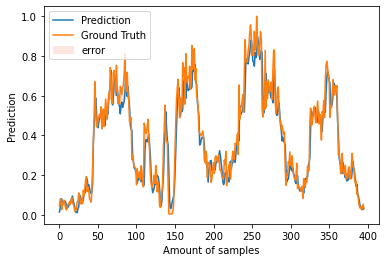

In [25]:
# 查看train集预测结果
pred_train_y = my_model.predict(train_X)
plt.plot(range(len(pred_train_y)), pred_train_y, label='Prediction')
plt.plot(range(len(pred_train_y)), train_y, label='Ground Truth')
plt.fill_between(range(len(pred_train_y)), pred_train_y.flatten(), train_y.flatten(), color='MistyRose',label='error')
plt.xlabel('Amount of samples')
plt.ylabel('Prediction')
plt.legend()
plt.show()

4/4 [==============================] - 0s 3ms/step
0.24938274254738801


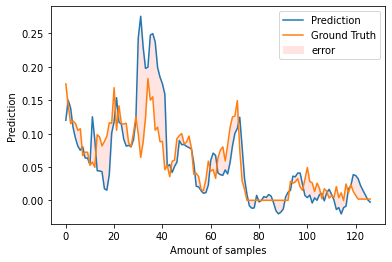

In [26]:
# 查看valid集预测结果
pred_valid_y = my_model.predict(valid_X)
print(ev(valid_y,pred_valid_y))
plt.plot(range(len(pred_valid_y)), pred_valid_y, label='Prediction')
plt.plot(range(len(pred_valid_y)), valid_y, label='Ground Truth')
plt.fill_between(range(len(pred_valid_y)), pred_valid_y.flatten(), valid_y.flatten(), color='MistyRose',label='error')
plt.xlabel('Amount of samples')
plt.ylabel('Prediction')
plt.legend()
plt.show()

4/4 [==============================] - 0s 2ms/step


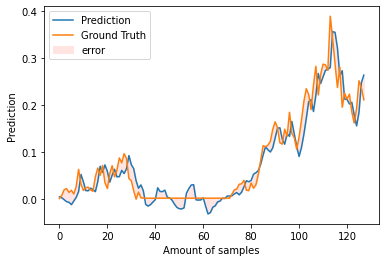

In [27]:
# 查看test集预测结果
pred_y = my_model.predict(test_X)
# %% Plotting
plt.plot(range(len(pred_y)), pred_y, label='Prediction')
plt.plot(range(len(pred_y)), test_y, label='Ground Truth')
plt.fill_between(range(len(pred_y)), pred_y.flatten(), test_y.flatten(), color='MistyRose',label='error')
plt.xlabel('Amount of samples')
plt.ylabel('Prediction')
plt.legend()
plt.show()
# %%

In [28]:
# 预测未来
# 从past数据中抽取7组作为未来数据的开头
df_30_days_past=df.iloc[-7:,:]
df_30_days_past.tail()

,Speed10,Direction10,Speed30,Direction30,Speed50,Direction50,Speed70,Direction70,Speed90,Direction90,Speed100,Direction100,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,,,,,,,,,,
2022-07-21 22:45:00,4.5521,307.3230,6.1812,312.0492,7.6793,314.6835,8.4867,316.0503,8.6879,316.8657,8.7815,317.1689,27.90,1009.53,87.03,2.3584
2022-07-21 23:00:00,4.5931,308.9910,5.4076,312.4519,6.1518,314.8683,6.7197,316.4472,6.8998,317.2906,6.9864,317.6105,27.92,1010.14,0.00,2.8011
2022-07-21 23:15:00,3.3338,303.4994,4.6673,310.4815,5.9120,314.1776,6.7329,316.0832,6.9197,316.9911,7.0061,317.3137,27.44,1009.89,0.00,3.6597
2022-07-21 23:30:00,3.2299,299.8989,4.5556,308.4045,5.8027,312.7652,6.6115,314.9387,6.7961,315.8942,6.8890,316.2939,27.46,1009.84,0.00,3.4466
2022-07-21 23:45:00,3.4215,297.3140,4.7503,306.2668,6.0103,311.0873,6.7556,313.3806,6.9372,314.3576,7.0216,314.8269,27.46,1009.69,0.00,3.0725


In [29]:
# 提取未来数据
df_30_days_future=pd.read_csv('.\\data\\FD001\\04 Fore_NWP_FD.csv',parse_dates=["Datetime"],index_col=[0])
df_30_days_future.shape
df_30_days_future["Power(MW)"]=0 # 为方便后续操作，为未来数据添加一power列
print(df_30_days_future.shape)
df_30_days_future.head(10)

(672, 16)


,Speed10,Direction10,Speed30,Direction30,Speed50,Direction50,Speed70,Direction70,Speed90,Direction90,Speed100,Direction100,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,,,,,,,,,,
2022-07-22 00:00:00,3.7211,295.8076,5.0066,304.4201,6.2332,309.2053,7.0688,311.6739,7.2327,312.6467,7.3154,313.1167,27.48,1009.94,91.75,0
2022-07-22 00:15:00,3.8066,293.5346,5.0170,301.8843,6.1681,306.6284,7.2085,309.6529,7.3615,310.5929,7.4355,311.0192,27.50,1010.59,91.66,0
2022-07-22 00:30:00,3.6731,294.9604,4.9233,302.9800,6.1044,307.5457,7.1653,310.3584,7.3207,311.1786,7.4027,311.5500,27.49,1010.61,91.58,0
2022-07-22 00:45:00,3.5422,297.2161,4.8605,305.0306,6.0974,309.2762,7.0755,311.7344,7.2339,312.4229,7.3028,312.7803,27.49,1010.30,91.49,0
2022-07-22 01:00:00,3.3743,298.6918,4.7401,306.5073,6.0209,310.6219,6.9490,312.7840,7.1021,313.4025,7.1718,313.7571,27.49,1010.12,91.35,0
2022-07-22 01:15:00,3.1295,299.2680,4.5283,307.5532,5.8439,311.6010,6.7476,313.6789,6.9019,314.2956,6.9723,314.5351,27.50,1010.01,91.16,0
2022-07-22 01:30:00,2.9396,301.3649,4.3891,309.6384,5.7438,313.4480,6.5762,315.2464,6.7394,315.7815,6.8105,316.0113,27.52,1009.78,90.95,0
2022-07-22 01:45:00,2.7215,304.9748,4.1895,312.6785,5.5593,316.3119,6.3285,317.6898,6.5016,318.2420,6.5739,318.4533,27.54,1009.64,90.70,0
2022-07-22 02:00:00,3.7854,312.9661,5.0859,316.5137,6.2700,318.5562,6.9863,319.4699,7.1805,319.7449,7.2816,319.9023,26.16,1009.70,0.00,0


In [30]:
# 归一化过去数据
old_scaled_array=scaler.transform(df_30_days_past)
old_scaled_array.shape

(7, 16)

In [31]:
# 归一化未来数据
new_scaled_array=scaler.transform(df_30_days_future)
new_scaled_array.shape

(672, 16)

In [32]:
new_scaled_df=pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,-1]=np.nan #将未来数据表中power转为NaN
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1) #合并表格
full_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.414045,0.857602,0.548232,0.867055,0.656629,0.875036,0.664974,0.875789,0.648350,0.877727,0.640991,0.878917,0.366730,0.914182,0.857763,0.223696
1,0.408111,0.856113,0.538970,0.866919,0.644206,0.875570,0.661963,0.876982,0.646125,0.879029,0.638873,0.880462,0.362949,0.933153,0.858652,0.185839
2,0.404852,0.855214,0.532911,0.867376,0.636724,0.876724,0.660225,0.878446,0.644585,0.880723,0.637369,0.881884,0.362949,0.944896,0.859046,0.162282
3,0.408989,0.859874,0.460468,0.868497,0.502896,0.877239,0.508179,0.879550,0.497273,0.881905,0.492234,0.883112,0.366730,1.000000,0.000000,0.192892
4,0.281913,0.844532,0.391143,0.863016,0.481886,0.875314,0.509315,0.878537,0.498913,0.881072,0.493827,0.882287,0.275992,0.977416,0.000000,0.252259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,0.277897,0.145466,0.280334,0.137854,0.283786,0.130938,0.259140,0.123722,0.257081,0.117988,0.255504,0.115957,0.542533,0.498645,0.840983,NaN
675,0.262326,0.152830,0.265191,0.144985,0.271529,0.137923,0.245958,0.130437,0.245160,0.124788,0.244136,0.122822,0.546314,0.517615,0.840391,NaN
676,0.250045,0.156756,0.254881,0.148878,0.262215,0.141645,0.237809,0.134375,0.237127,0.129013,0.236698,0.127183,0.548204,0.532069,0.841477,NaN
677,0.253456,0.157889,0.258880,0.151011,0.265913,0.144410,0.242533,0.137648,0.242672,0.132782,0.242026,0.130913,0.548204,0.550136,0.844931,NaN


In [ ]:
# 开始逐点预测
full_df_scaled_array=full_df.values
all_data=[]
time_step=7
for i in range(time_step,len(full_df_scaled_array)):
      data_x=[]
      data_x.append( full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]])
      data_x=np.array(data_x)
      prediction=my_model.predict(data_x)
      if prediction<0:
            prediction=0
      all_data.append(prediction)
      full_df.iloc[i,-1]=prediction

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 15ms/step


In [ ]:
all_data=np.array(all_data).flatten()

In [ ]:
# 这是没有经过归一化逆变换的图
plt.plot(range(len(np.array(all_data))), all_data, label='Prediction')

In [ ]:
# # 这块地方涉及归一化的反变换，但是我感觉有点问题
# new_array=np.array(all_data)
# new_array=new_array.reshape(-1,1)
# prediction_copies_array = np.repeat(new_array,16, axis=-1)
# y_pred_future_30_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),16)))[:,0]
# print(y_pred_future_30_days)
# # 查看预测结果
# plt.plot(range(len(y_pred_future_30_days)), y_pred_future_30_days, label='Prediction')
# #绘制整体发电量图
# total = np.hstack((df_y,y_pred_future_30_days))
# plt.plot(range(len(total)), total, label='Prediction',color='coral')
# plt.plot(range(len(df_y)), df_y, label='Prediction')

In [ ]:
#绘制整体发电量图
total = np.hstack((df_scaled_y,all_data))
plt.plot(range(len(total)), total, label='Prediction',color='coral')
plt.plot(range(len(df_scaled_y)), df_scaled_y, label='Prediction')